## load libraries

In [1]:
library(here)
library(stringr)
library(dplyr)
library(ggplot2)
library(Seurat)
library(purrr)
library(readr)
library(patchwork)
library(scCustomize)
library(tidyverse)
#library(harmony)
#library(SeuratDisk)

here() starts at /test




Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


scCustomize v2.1.2
If you find the scCustomize useful please cite.
See 'samuel-marsh.github.io/scCustomize/articles/FAQ.html' for citation info.

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## load data

In [2]:
counts <- Read10X_GEO(
    data_dir = here("data")
)

Reading 10X files from directory


In [3]:
for (sample in names(counts)) {
    colnames(counts[[sample]]) <- gsub("^2_", "", colnames(counts[[sample]]))
}

In [4]:
# Create Seurat object for the control sample
control_seurat <- CreateSeuratObject(
    counts = counts$GSM8494123_control_, 
    project = "control"
)
high_glucose_seurat <- CreateSeuratObject(
    counts = counts$GSM8494124_high_glucose_, 
    project = "high_glucose"
)

# Add sample IDs as cell barcode prefixes to avoid duplicates
merged_seurat <- merge(
    x = control_seurat, 
    y = high_glucose_seurat, 
    add.cell.ids = c("control", "high_glucose")
)

# Inspect the combined object
merged_seurat


Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Data is of class dgTMatrix. Coercing to dgCMatrix.”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Data is of class dgTMatrix. Coercing to dgCMatrix.”


An object of class Seurat 
32521 features across 15863 samples within 1 assay 
Active assay: RNA (32521 features, 0 variable features)
 2 layers present: counts.control, counts.high_glucose

## quality control metrics

In [5]:
merged_seurat[["log1p_nCount_RNA"]] <- log1p(merged_seurat@meta.data$nCount_RNA)

merged_seurat[["log1p_nFeature_RNA"]] <- log1p(merged_seurat@meta.data$nFeature_RNA)

# Calculate the percentage of counts in the top 20 highly expressed features for each condition
merged_seurat[["pct_counts_in_top_20_genes"]] <- apply(
  as.matrix(GetAssayData(object = merged_seurat, assay = "RNA", layer = "counts.control")),
  MARGIN = 2,  # Loop over cells (columns)
  FUN = function(x) {
    sum(sort(x, decreasing = TRUE)[1:20]) / sum(x) * 100
  }
)

merged_seurat[["pct_counts_in_top_20_genes"]] <- apply(
  as.matrix(GetAssayData(object = merged_seurat, assay = "RNA", layer = "counts.high_glucose")),
  MARGIN = 2,  # Loop over cells (columns)
  FUN = function(x) {
    sum(sort(x, decreasing = TRUE)[1:20]) / sum(x) * 100
  }
)

merged_seurat[["pct_counts_mt"]] <- PercentageFeatureSet(merged_seurat, pattern = "^mt-")


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 2.4 GiB”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.4 GiB”


## filter low quality cells

With adaptive thresholds


FALSE 
15863 


FALSE  TRUE 
11105  4758 

Total cells before filtering: 15863 
Total cells after filtering: 11105 


Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”


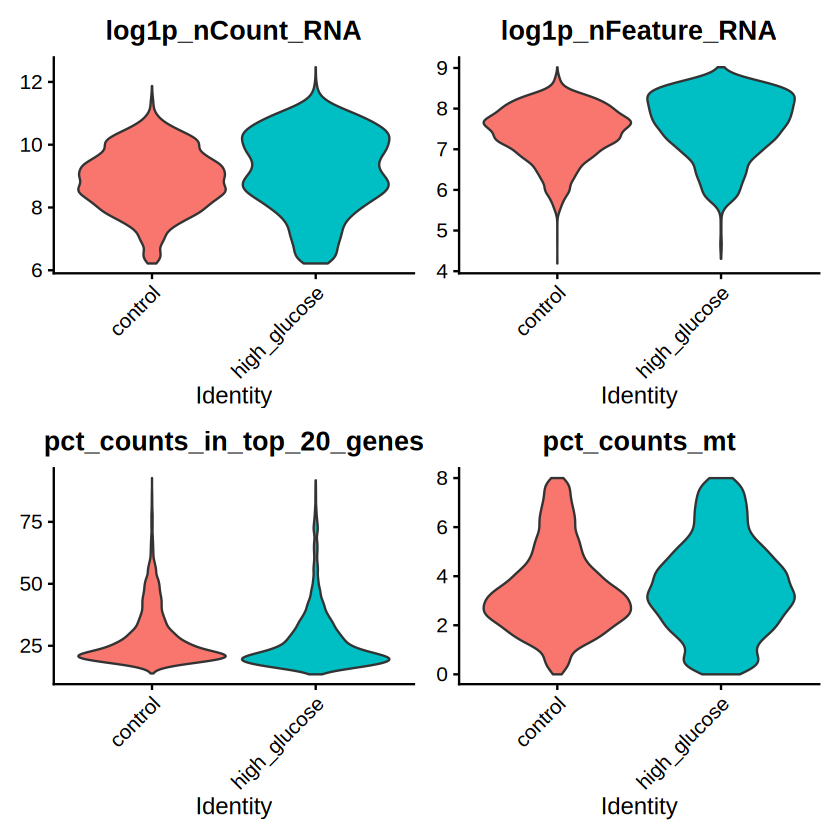

In [6]:
is_outlier <- function(data, metric, nmads) {
  M <- data[[metric]]
  outlier <- (M < median(M, na.rm = TRUE) - nmads * mad(M, na.rm = TRUE)) |
             (M > median(M, na.rm = TRUE) + nmads * mad(M, na.rm = TRUE))
  return(outlier)
}

# Apply the function to detect outliers in QC metrics
merged_seurat@meta.data$outlier <- (
  is_outlier(merged_seurat@meta.data, "log1p_nCount_RNA", 5) |
  is_outlier(merged_seurat@meta.data, "log1p_nFeature_RNA", 5)|
  is_outlier(merged_seurat@meta.data, "pct_counts_in_top_20_genes", 5)
)

# Apply the function for mitochondrial percentage with a stricter threshold
merged_seurat@meta.data$mt_outlier <- (
  is_outlier(merged_seurat@meta.data, "pct_counts_mt", 3) |
  (merged_seurat@meta.data$pct_counts_mt > 8)
)

# Count outliers
table(merged_seurat@meta.data$outlier)
table(merged_seurat@meta.data$mt_outlier)

filtered_seurat <- subset(merged_seurat, subset = outlier == FALSE & mt_outlier == FALSE)

# Display the number of cells before and after filtering
cat("Total cells before filtering:", ncol(merged_seurat), "\n")
cat("Total cells after filtering:", ncol(filtered_seurat), "\n")

# Visualize QC metrics as a violin plot
VlnPlot(filtered_seurat, features = c("log1p_nCount_RNA", "log1p_nFeature_RNA", "pct_counts_in_top_20_genes", "pct_counts_mt"), ncol = 2,pt.size = 0)

In [8]:
saveRDS(filtered_seurat, file = here("seurat/filtered_seurat.rds"))
